<a href="https://colab.research.google.com/github/cincinnatilibrary/collection-analysis/blob/master/reports/google_colab_report_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHPL - Collection Analysis - **Google Colab Template**
<img src="https://ilsweb.cincinnatilibrary.org/img/CHPL_Brandmark_Primary.png" alt="CHPL" title="CHPL" width="300"/>

Use this as a template for new reports

Data sources / Documentation:

* https://ilsweb.cincinnatilibrary.org/collection-analysis/

In [ ]:
!pip install -U altair_saver
!pip install selenium
!apt-get install chromium-chromedriver

In [6]:
import pandas as pd
import numpy as np
import altair as alt
# if we want to save output as .png use this
# NOTE: use !pip install -U altair_saver above to download / install first
from altair_saver import save
from urllib.parse import urlencode

In [7]:
# engine = create_engine('sqlite:///file:current.db?mode=rw&uri=true')

# instead of the local db, we'll use the current_collection data set instead ...
# NOTE: the queries change slighly from the local db
chpl_collection_url = 'https://ilsweb.cincinnatilibrary.org/collection-analysis/current_collection'

In [8]:
# Example query:
# find the percent of of items currently checked out from branch location

# NOTE: this query contains a param we can use to select the name of the branch
sql = """\
with item_data as (
  select
    -- location_code,
    branch_name.name,
    item.item_format,
    count(item.item_record_num) as count_items,
    count(item.due_date) as count_current_checkout,
    sum(checkout_total) as sum_checkout_total,
    sum(renewal_total) as sum_renewal_total,
    sum(price_cents) / 100.0 as sum_price
  from
    item
    join "location" as loc on loc.code = item.location_code
    join branch on branch.code_num = loc.branch_code_num
    join branch_name on branch_name.branch_id = branch.id
  where
    branch_name.name = :branch_name
  group by
    1,
    2
)
select
  name as branch_name,
  item_format,
  count_items,
  count_current_checkout,
  sum_checkout_total,
  round(
    (
      (count_current_checkout * 1.0) / (count_items * 1.0)
    ) * 100.0,
    2
  ) as percent_checked_out,
  sum_renewal_total,
  sum_price
from
  item_data
"""

branch_name = "Deer Park"

df = pd.read_csv(
    chpl_collection_url 
    + '.csv?' 
    + urlencode(
        query={'sql': sql, 'branch_name': branch_name}
      )
)

df.head()

,branch_name,item_format,count_items,count_current_checkout,sum_checkout_total,percent_checked_out,sum_renewal_total,sum_price
0,Deer Park,Audio Enabled Juvenile Book,113,40,649,35.40,198,5402.07
1,Deer Park,Bike Locks,3,0,0,0.00,0,30.00
2,Deer Park,Book,15806,3171,179128,20.06,118591,380830.53
3,Deer Park,Book on CD,893,158,25140,17.69,13033,45030.18
4,Deer Park,Charging Kit,5,1,117,20.00,0,25.00


In [9]:
chart = alt.Chart(df).mark_bar(color="#0090bd").encode(
    # x='end_date:T',
    x=alt.X(
        'item_format',
        axis=alt.Axis(title='Item Format', labelAngle=-70),
        sort='-y'
    ),
    y=alt.Y(
        'percent_checked_out:Q',
        title = 'Percent of Total Checked Out',
        scale = alt.Scale(domain=[0,100]),
    ),
    tooltip=['branch_name', 'item_format', 'percent_checked_out', 'count_items', 'count_current_checkout', 'sum_checkout_total', 'sum_renewal_total', 'sum_price']
).properties(
    title="{} -- Percent Checked Out by Item-type".format(df.iloc[0]['branch_name']),
    width=900,
)

chart.display()

# we can save this file to an html file: name + date if that's what we want
chart.save(
    'output-{}.html'.format(
        pd.Timestamp('now').strftime('%Y-%m-%d')
    )
)

# remember, if we want to use this, import altair_saver (and requirements) above
save(chart, "chart.png")

alt.Chart(...)

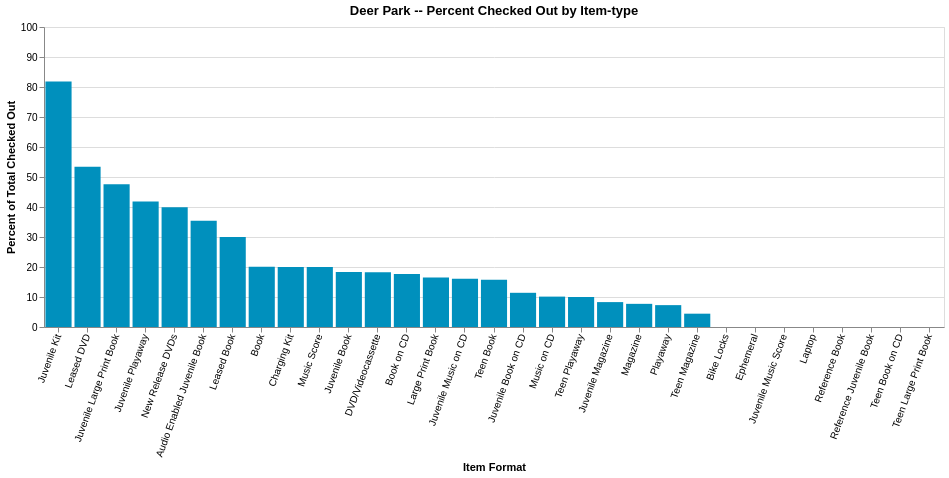

In [10]:
# just doing this for example purposes
from IPython.display import Image
Image('chart.png')